In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from PIL import Image
import os

PROJECT_PATH = "/content/drive/MyDrive/Colab Notebooks/Final Year Project"

# List contents of the folder
print(os.listdir(PROJECT_PATH))
import pandas as pd

CSV_PATH = os.path.join(PROJECT_PATH, "list_attr_celeba.csv")  # Update filename if different

# Load the CSV file
df = pd.read_csv(CSV_PATH)

# Display first few rows
print(df.head())
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize to [-1,1]
])

# Path to images folder
IMG_FOLDER_PATH = os.path.join(PROJECT_PATH, "img_align_celeba")  # Update if different

# Load the dataset
dataset = datasets.ImageFolder(root=IMG_FOLDER_PATH, transform=transform)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

['list_attr_celeba.csv', 'img_align_celeba']
     image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair 

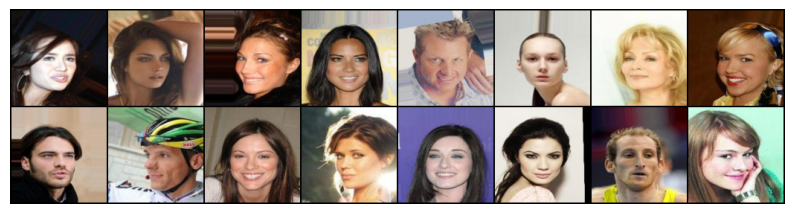

In [ ]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Get a batch of images
data_iter = iter(dataloader)
images, _ = next(data_iter)

# Display images
plt.figure(figsize=(10,10))
plt.imshow(vutils.make_grid(images[:16], normalize=True).permute(1, 2, 0))
plt.axis('off')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize
])

# Custom dataset to load image and text description
class SketchDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])  # Image filename
        image = Image.open(img_name).convert("RGB")
        description = self.dataframe.iloc[idx, 1]  # Assuming 2nd column has descriptions

        if self.transform:
            image = self.transform(image)

        return image, description

# Define dataset
IMAGE_PATH = os.path.join(PROJECT_PATH, "img_align_celeba")  # Correct path

# Define transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to match model input size
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create dataset
dataset = datasets.ImageFolder(root=IMAGE_PATH, transform=transform)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)


In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 3*64*64),  # Output size (3, 64, 64) for RGB images
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 3, 64, 64)

# Define Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3*64*64, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img.view(-1, 3*64*64))

# Instantiate models
generator = Generator().cuda()
discriminator = Discriminator().cuda()

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader

# Increase dataset size for better learning
small_dataset = Subset(dataset, range(1000))  # Use 1000 samples
small_dataloader = DataLoader(small_dataset, batch_size=64, shuffle=True)

# Loss and Optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.00015, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.00015, betas=(0.5, 0.999))

# Training Loop (More batches for better learning)
num_epochs = 80  # Reduce epochs slightly for efficiency
num_batches = 20  # Train on 20 batches per epoch

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(small_dataloader):
        if i >= num_batches:
            break

        real_images = images.cuda()
        batch_size = real_images.size(0)

        # Labels for real and fake images
        real_labels = torch.ones(batch_size, 1).cuda()
        fake_labels = torch.zeros(batch_size, 1).cuda()

        # Train Discriminator
        optimizer_D.zero_grad()
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)

        z = torch.randn(batch_size, 100).cuda()

        fake_images = generator(z)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        g_loss.backward()
        optimizer_G.step()

    if epoch % 10 == 0:  # Print loss every 10 epochs
        print(f"Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch [1/80] | D Loss: 0.7691 | G Loss: 0.7986
Epoch [11/80] | D Loss: 0.4661 | G Loss: 1.0940
Epoch [21/80] | D Loss: 0.5727 | G Loss: 2.2497
Epoch [31/80] | D Loss: 0.5796 | G Loss: 1.5157
Epoch [41/80] | D Loss: 1.2055 | G Loss: 1.6564
Epoch [51/80] | D Loss: 0.5323 | G Loss: 0.8028
Epoch [61/80] | D Loss: 0.2603 | G Loss: 2.4665
Epoch [71/80] | D Loss: 0.3423 | G Loss: 1.4181


Enter the description of the face: A man with short hairs and narrow eyes


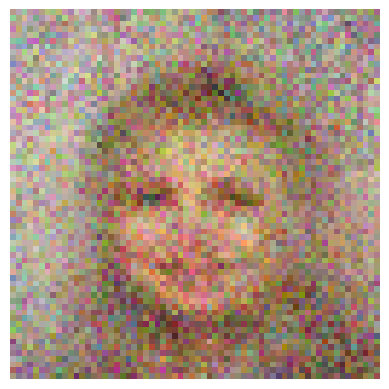

In [ ]:
import matplotlib.pyplot as plt
import torch

def generate_sketch():
    description = input("Enter the description of the face: ")  # User input (not used yet)

    z = torch.randn(1, 100).cuda()  # Random noise
    generated_image = generator(z).cpu().detach().numpy().reshape(3, 64, 64)  # Reshape to (C, H, W)

    # Normalize to range [0,1]
    generated_image = (generated_image - generated_image.min()) / (generated_image.max() - generated_image.min())

    plt.imshow(generated_image.transpose(1, 2, 0))  # Adjust shape for RGB display
    plt.axis('off')
    plt.show()

generate_sketch()